In [1]:
import pandas as pd 
import os
import re

from nltk.stem import PorterStemmer
from matplotlib import pyplot as plt
from collections import defaultdict, Counter

In [2]:
BASE_PATH = os.path.join(os.getcwd(), os.pardir)
DATA_PATH = os.path.join(BASE_PATH, 'data')

In [3]:
train_df = pd.read_json(os.path.join(DATA_PATH, 'train.json.zip'))

# Extract text/numerical/categorical features

Let's extract out hte number of bathrooms and bedrooms, the building ID, the latitude, the longitude, the manager ID and the price since these are trivial to extract

In [4]:
bathrooms = train_df['bathrooms']
bedrooms = train_df['bedrooms']
building_ids = train_df['building_id']
latitudes = train_df['latitude']
longitudes = train_df['longitude']
manager_ids = train_df['manager_id']
prices = train_df['price']

Now we can extract the month, day, hour and weekday from the creation timestamp

In [5]:
datetime = pd.to_datetime(train_df['created'])

In [6]:
months = datetime.dt.month
days = datetime.dt.day
hours = datetime.dt.hour

In [7]:
# Where Monday = 0, and Sunday = 6
weekdays = datetime.dt.dayofweek

Now we can extract the number of pictures for each listing

In [8]:
num_photos = train_df['photos'].str.len()

Now let's extract the 'features' column, which is a harder task

Methodology of: https://www.kaggle.com/jxnlco/deduplicating-features

In [9]:
features = train_df['features'].apply(lambda x: [i.lower() for i in x])

We eliminate all features that appear less than $n$ times

In [10]:
n = 5

feature_counts = Counter()
for feature in features.tolist():
    feature_counts.update(feature)
feature = sorted([k for (k,v) in feature_counts.items() if v > n])
feature[:10]

['24/7 concierge',
 '24/7 doorman',
 '24hr doorman',
 'a full service luxury highrise',
 'actual apt. photos',
 'air conditioning',
 'all utilities included',
 'assigned-parking-space',
 'attended lobby',
 'backyard']

Since we have a lot of duplicates, we can clean things up to eliminate them. We use the first 4 characters of a feature in order to group together different features.

In [11]:
def clean(s):
    x = s.replace("-", "")
    x = x.replace(" ", "")
    x = x.replace("twenty four hour", "24")
    x = x.replace("24/7", "24")
    x = x.replace("24hr", "24")
    x = x.replace("24-hour", "24")
    x = x.replace("24hour", "24")
    x = x.replace("24 hour", "24")
    x = x.replace("common", "cm")
    x = x.replace("concierge", "doorman")
    x = x.replace("bicycle", "bike")
    x = x.replace("private", "pv")
    x = x.replace("deco", "dc")
    x = x.replace("decorative", "dc")
    x = x.replace("onsite", "os")
    x = x.replace("outdoor", "od")
    x = x.replace("ss appliances", "stainless")
    return x

def feature_hash(x):
    cleaned = clean(x, uniq)
    key = cleaned[:4].strip()
    return key

In [12]:
key2original = defaultdict(list)
k = 4
for f in feature:
    cleaned = clean(f)
    key = cleaned[:k].strip()
    key2original[key].append(f)

In [13]:
key2original

defaultdict(list,
            {'24do': ['24/7 concierge', '24/7 doorman', '24hr doorman'],
             'aful': ['a full service luxury highrise'],
             'actu': ['actual apt. photos'],
             'airc': ['air conditioning'],
             'allu': ['all utilities included'],
             'assi': ['assigned-parking-space'],
             'atte': ['attended lobby'],
             'back': ['backyard'],
             'balc': ['balcony'],
             'base': ['basement storage'],
             'bike': ['bike room', 'bike storage'],
             'bill': ['billiards room'],
             'brea': ['breakfast bar'],
             'brow': ['brownstone'],
             'buil': ['building-common-outdoor-space'],
             'busi': ['business center'],
             'cabl': ['cable/satellite tv'],
             'cats': ['cats allowed'],
             'cent': ['central a/c', 'central ac', 'central air'],
             'chef': ['chefs kitchen'],
             'chil': ["children's playroom", 'children

In [14]:
columns = list(key2original.keys())

In [15]:
original2key = {}
for col in columns:
    for original in key2original[col]:
        original2key[original] = col

In [16]:
original2key

{'24/7 concierge': '24do',
 '24/7 doorman': '24do',
 '24hr doorman': '24do',
 'a full service luxury highrise': 'aful',
 'actual apt. photos': 'actu',
 'air conditioning': 'airc',
 'all utilities included': 'allu',
 'assigned-parking-space': 'assi',
 'attended lobby': 'atte',
 'backyard': 'back',
 'balcony': 'balc',
 'basement storage': 'base',
 'bike room': 'bike',
 'bike storage': 'bike',
 'billiards room': 'bill',
 'breakfast bar': 'brea',
 'brownstone': 'brow',
 'building-common-outdoor-space': 'buil',
 'business center': 'busi',
 'cable/satellite tv': 'cabl',
 'cats allowed': 'cats',
 'central a/c': 'cent',
 'central ac': 'cent',
 'central air': 'cent',
 'chefs kitchen': 'chef',
 "children's playroom": 'chil',
 'childrens playroom': 'chil',
 'cinema room': 'cine',
 'city view': 'city',
 'close to subway': 'clos',
 'closets galore!': 'clos',
 'common backyard': 'cmba',
 'common garden': 'cmga',
 'common outdoor space': 'cmod',
 'common parking/garage': 'cmpa',
 'common roof deck': 

In [17]:
all_listing_features = {}

for index,row in train_df.iterrows():
    listing_features = {}
    features_found = []
    for feature in row['features']:
        feature = feature.lower()
        if feature in original2key:
            features_found.append(original2key[feature])
    for feature in columns:
            if feature not in features_found:
                listing_features[feature] = 0
            else:
                listing_features[feature] = 1
    all_listing_features[row['listing_id']] = listing_features
    
one_hot_features = pd.DataFrame.from_dict(all_listing_features, orient='index')

In [18]:
one_hot_features

,24do,aful,actu,airc,allu,assi,atte,back,balc,base,...,tons,vale,vide,view,virt,walk,wash,whee,wifi,wood
7170325,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7092344,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7158677,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7211212,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7225292,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6824800,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6813268,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6927093,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6892816,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we can try extracting features from the "Description" column

Methodology of: https://www.kaggle.com/ug2409/using-description-as-the-only-feature-72-cv

In [19]:
descriptions = train_df[['description']]

In [20]:
# Removes symbols, numbers and stem the words to reduce dimentional space
stemmer = PorterStemmer()

def clean(x):
    regex = re.compile('[^a-zA-Z ]')
    # For user clarity, broken it into three steps
    i = regex.sub(' ', x).lower()
    i = i.split(" ") 
    i= [stemmer.stem(l) for l in i]
    i= " ".join([l.strip() for l in i if (len(l)>2) ]) # Keeping words that have length greater than 2
    return i

In [21]:
descriptions['description_new'] = descriptions.description.apply(lambda x: clean(x))

/home/mnguyen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [22]:
descriptions.head()

,description,description_new
4,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,spaciou bedroom bathroom williamsburg apart fe...
6,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,brand new gut renov true bedroomfind yourself ...
9,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,flex bedroom with full pressur wall look for t...
10,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,brand new bedroom bath apartmentenjoy these fo...
15,Over-sized Studio w abundant closets. Availabl...,over size studio abund closet avail immedi ren...


In [23]:
from sklearn.feature_extraction.text import CountVectorizer #Can use tfidffvectorizer as well

cvect_desc = CountVectorizer(stop_words='english', max_features=200)
full_sparse = cvect_desc.fit_transform(descriptions.description_new)

# Renaming words to avoid collisions with other feature names in the model
col_desc = ['desc_'+ i for i in cvect_desc.get_feature_names()] 
count_vect_df = pd.DataFrame(full_sparse.todense(), columns=col_desc)
descriptions = pd.concat([descriptions.reset_index(), count_vect_df],axis=1)

In [24]:
descriptions = descriptions.drop(labels=['description', 'index', 'description_new'], axis=1)

In [25]:
descriptions.index = train_df['listing_id']
descriptions

,desc_access,desc_allow,desc_amaz,desc_amen,desc_amp,desc_ani,desc_apart,desc_applianc,desc_appoint,desc_area,...,desc_walk,desc_wall,desc_washer,desc_water,desc_websit,desc_west,desc_white,desc_window,desc_wood,desc_york
listing_id,,,,,,,,,,,,,,,,,,,,,
7170325,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,1,0,0,0,0,0
7092344,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,1,0,0,0,0,0
7158677,0,0,0,0,0,0,5,1,0,0,...,0,1,0,0,1,0,0,0,0,0
7211212,0,0,0,0,0,0,2,1,0,1,...,0,0,1,0,1,0,0,0,0,0
7225292,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6824800,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,1,0,0,0,0,1
6813268,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,3,0,0,0,0,1
6927093,0,0,0,1,0,0,1,1,0,0,...,0,0,0,1,1,0,0,0,0,0


Now we can make one final dataframe which has all the columns. We can perform feature selection on this at a later time.

In [26]:
final_train_df = pd.DataFrame()

In [27]:
final_train_df['bathrooms'] = bathrooms
final_train_df['bedrooms'] = bedrooms
final_train_df['building_ids'] = building_ids 
final_train_df['latitudes'] = latitudes
final_train_df['longitudes'] = longitudes
final_train_df['manager_ids'] = manager_ids
final_train_df['prices'] = prices

In [28]:
final_train_df['months'] = months
final_train_df['days'] = days
final_train_df['hours'] = hours
final_train_df['weekdays'] = weekdays

In [29]:
final_train_df['num_photos'] = num_photos

In [30]:
final_train_df.index = train_df['listing_id']
final_train_df

,bathrooms,bedrooms,building_ids,latitudes,longitudes,manager_ids,prices,months,days,hours,weekdays,num_photos
listing_id,,,,,,,,,,,,
7170325,1.0,1,8579a0b0d54db803821a35a4a615e97a,40.7108,-73.9539,a10db4590843d78c784171a107bdacb4,2400,6,16,5,3,12
7092344,1.0,2,b8e75fc949a6cd8225b455648a951712,40.7513,-73.9722,955db33477af4f40004820b4aed804a0,3800,6,1,5,2,6
7158677,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,40.7575,-73.9625,c8b10a317b766204f08e613cef4ce7a0,3495,6,14,15,1,6
7211212,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,40.7145,-73.9425,5ba989232d0489da1b5f2c45f6688adc,3000,6,24,7,4,5
7225292,1.0,0,bfb9405149bfff42a92980b594c28234,40.7439,-73.9743,2c3b41f588fbb5234d8a1e885a436cfa,2795,6,28,3,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
6824800,1.0,3,92bbbf38baadfde0576fc496bd41749c,40.8433,-73.9396,a61e21da3ba18c7a3d54cfdcc247e1f8,2800,4,5,3,1,5
6813268,1.0,2,5565db9b7cba3603834c4aa6f2950960,40.8198,-73.9578,8f90e5e10e8a2d7cf997f016d89230eb,2395,4,2,2,5,5
6927093,1.0,1,67997a128056ee1ed7d046bbb856e3c7,40.5765,-73.9554,a10db4590843d78c784171a107bdacb4,1850,4,26,5,1,3


In [31]:
final_train_df = final_train_df.merge(descriptions, left_index=True, right_index=True)

In [32]:
final_train_df = final_train_df.merge(one_hot_features, left_index=True, right_index=True)

Now we can perform one-hot encoding on the building_ids and manager_ids

In [38]:
final_train_df = pd.concat([final_train_df, pd.get_dummies(final_train_df['building_ids'], prefix='building')], axis=1)
final_train_df = pd.concat([final_train_df, pd.get_dummies(final_train_df['manager_ids'], prefix='manager')], axis=1)

In [40]:
final_train_df = final_train_df.drop(['building_ids', 'manager_ids'], axis=1)

In [41]:
final_train_df

,bathrooms,bedrooms,latitudes,longitudes,prices,months,days,hours,weekdays,num_photos,...,manager_ff50149b1ec6a10fbb386d761c7a4bc5,manager_ff52574a198d8a349f41d57bd374e8e9,manager_ff564542a40d3e9b970a494df91b4cee,manager_ff5a3509ebce238dfa4857839ddd24ce,manager_ff707b7f0a2ea94a26c784f06c9fec69,manager_ff810b43aecfacd00f20a2912ff1e288,manager_ff8f1175d95c5a866ef73399cd54a1a1,manager_ffb9eceeaa4d60da7b41cc8f0954cd50,manager_ffd3c60281949a5cd806030203a79558,manager_ffd7307e4924587b30ec014a95db1362
7170325,1.0,1,40.7108,-73.9539,2400,6,16,5,3,12,...,0,0,0,0,0,0,0,0,0,0
7092344,1.0,2,40.7513,-73.9722,3800,6,1,5,2,6,...,0,0,0,0,0,0,0,0,0,0
7158677,1.0,2,40.7575,-73.9625,3495,6,14,15,1,6,...,0,0,0,0,0,0,0,0,0,0
7211212,1.5,3,40.7145,-73.9425,3000,6,24,7,4,5,...,0,0,0,0,0,0,0,0,0,0
7225292,1.0,0,40.7439,-73.9743,2795,6,28,3,1,4,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6824800,1.0,3,40.8433,-73.9396,2800,4,5,3,1,5,...,0,0,0,0,0,0,0,0,0,0
6813268,1.0,2,40.8198,-73.9578,2395,4,2,2,5,5,...,0,0,0,0,0,0,0,0,0,0
6927093,1.0,1,40.5765,-73.9554,1850,4,26,5,1,3,...,0,0,0,0,0,0,0,0,0,0
6892816,1.0,2,40.7448,-74.0017,4195,4,19,2,1,5,...,0,0,0,0,0,0,0,0,0,0


Let's calculate the mutual information for the target variable to get a head start on feature selection

In [34]:
from sklearn.feature_selection import mutual_info_classif

In [56]:
# For the main features
mutual_info_classif(final_train_df[['bathrooms', 'bedrooms', 'latitudes', 'longitudes', 'prices',
                                    'months', 'days', 'hours', 'weekdays', 'num_photos']], 
                                   train_df['interest_level'], random_state=667)

array([0.01400252, 0.00873072, 0.04042343, 0.03000614, 0.05876936,
       0.00231721, 0.00469537, 0.03053344, 0.        , 0.02422371])

We see that 'weekday' has a mutual info value of 0, meaning it is not important and is independent from the target labels. Now let's check this out for the one-hot encoded features

In [60]:
values = mutual_info_classif(descriptions, train_df['interest_level'], random_state=667)
values

array([3.07965841e-03, 0.00000000e+00, 2.61793018e-03, 3.58251950e-03,
       5.83791054e-03, 0.00000000e+00, 4.01113097e-05, 4.17201904e-03,
       1.15129589e-04, 0.00000000e+00, 8.91575917e-04, 0.00000000e+00,
       2.77387634e-04, 0.00000000e+00, 3.25647799e-03, 0.00000000e+00,
       5.58796287e-04, 0.00000000e+00, 4.91915044e-03, 2.71003189e-03,
       1.89450293e-03, 1.93635995e-03, 0.00000000e+00, 2.82918069e-03,
       2.46602156e-03, 2.38778741e-04, 0.00000000e+00, 0.00000000e+00,
       3.64035226e-03, 0.00000000e+00, 6.84479465e-04, 2.01959702e-03,
       0.00000000e+00, 2.00550262e-03, 1.76325343e-03, 2.13647306e-03,
       0.00000000e+00, 7.69864350e-03, 1.25789563e-03, 2.42976194e-03,
       3.02932437e-03, 4.18282236e-03, 0.00000000e+00, 4.80206172e-04,
       1.13388700e-03, 2.66789812e-03, 4.79801710e-04, 0.00000000e+00,
       3.61480463e-03, 1.40578760e-03, 3.28071620e-04, 3.62588906e-03,
       0.00000000e+00, 3.40291265e-03, 0.00000000e+00, 0.00000000e+00,
      

In [61]:
max(values)

0.014328444988887634

In [62]:
values = mutual_info_classif(one_hot_features, train_df['interest_level'], random_state=667)
values

array([0.00000000e+00, 1.22475661e-03, 1.49649635e-03, 6.15803149e-06,
       1.32427565e-03, 1.55443608e-03, 0.00000000e+00, 0.00000000e+00,
       3.75819580e-03, 0.00000000e+00, 1.54171636e-03, 0.00000000e+00,
       2.29911354e-03, 9.97463401e-04, 0.00000000e+00, 2.31064414e-03,
       0.00000000e+00, 5.50238527e-03, 3.37911356e-04, 2.48216600e-03,
       0.00000000e+00, 3.37525363e-04, 0.00000000e+00, 0.00000000e+00,
       1.02898991e-03, 0.00000000e+00, 0.00000000e+00, 2.14312623e-03,
       0.00000000e+00, 0.00000000e+00, 1.00316834e-04, 1.19715118e-03,
       1.81247249e-03, 3.85060802e-04, 4.18661599e-04, 0.00000000e+00,
       1.71899494e-03, 4.64816689e-05, 2.86926992e-03, 9.14897964e-03,
       3.12241634e-03, 3.73253873e-03, 1.69926372e-03, 1.36427271e-03,
       0.00000000e+00, 6.94981495e-03, 0.00000000e+00, 1.71508013e-03,
       1.99342688e-03, 1.72881301e-03, 0.00000000e+00, 1.10106051e-03,
       0.00000000e+00, 1.89643738e-03, 6.30424542e-03, 0.00000000e+00,
      

In [63]:
max(values)

0.013985754946577611

In [35]:
# Output it to a csv
final_train_df.to_csv(os.path.join(DATA_PATH, 'train_feats.tsv'), sep='\t')

# Extract image data 

Overall pipeline:

1) Iterate over URLS and download images.
2) Use scikit-learn to extract useful features.

In [36]:
train_df['photos']

4         [https://photos.renthop.com/2/7170325_3bb5ac84...
6         [https://photos.renthop.com/2/7092344_7663c19a...
9         [https://photos.renthop.com/2/7158677_c897a134...
10        [https://photos.renthop.com/2/7211212_1ed4542e...
15        [https://photos.renthop.com/2/7225292_901f1984...
                                ...                        
124000    [https://photos.renthop.com/2/6824800_0682be16...
124002    [https://photos.renthop.com/2/6813268_1e6fcc32...
124004    [https://photos.renthop.com/2/6927093_93a52104...
124008    [https://photos.renthop.com/2/6892816_1a8d087a...
124009    [https://photos.renthop.com/2/6901023_02052d90...
Name: photos, Length: 49352, dtype: object

In [45]:
import requests

In [47]:
for photo_list in train_df['photos']:
    for photo_url in photo_list:
        photo_filename = photo_url.split('/')[-1]
        output_dir = "D:\\rental_photos\\" + photo_filename
        
        
        with open(output_dir, 'wb') as f:
            f.write(requests.get(photo_url).content)

KeyboardInterrupt: 

Note: we interrupt the downloading process above, because the total size of the images is over 70 GB (compressed). Because of time constraints, for now we work with a small subset of 3374 images.

In [48]:
photo_dir = "D:\\rental_photos"

In [52]:
first_photo = "D:\\rental_photos\\" + os.listdir(photo_dir)[0]

In [53]:
from PIL import Image

img = Image.open(first_photo)

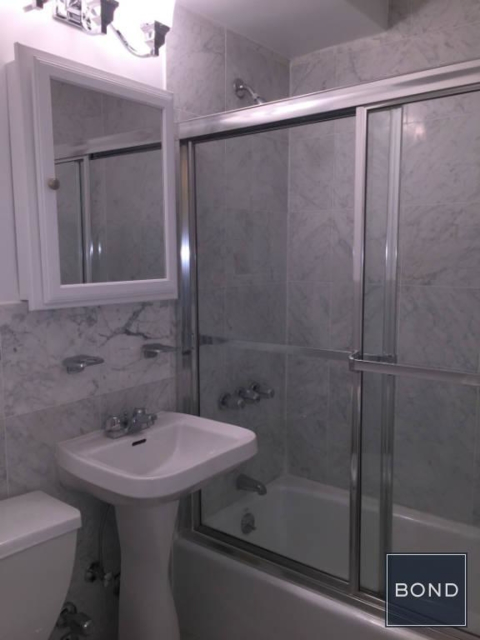

In [54]:
img

In [70]:
r,g,b = img.split()
r_hist = r.histogram()
g_hist = g.histogram()
b_hist = b.histogram()

<Figure size 432x288 with 0 Axes>

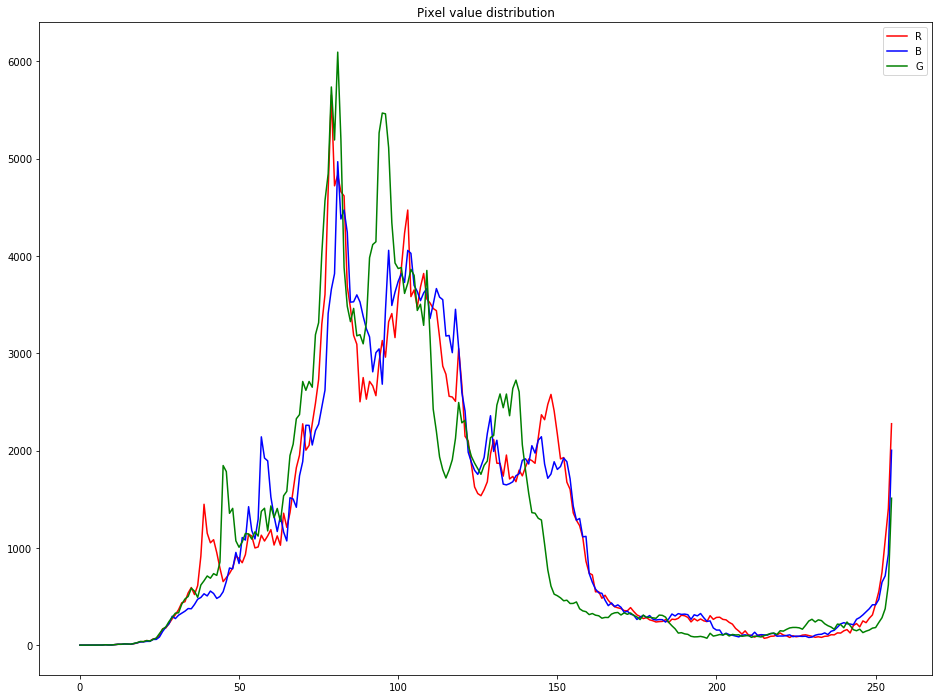

In [79]:
plt.clf()
plt.figure(figsize=(16,12))
plt.plot(r_hist, c='red', label='R')
plt.plot(b_hist, c='blue', label='B')
plt.plot(g_hist, c='green', label='G')
plt.title("Pixel value distribution")
plt.legend()
plt.show()

In [80]:
from sklearn import feature_extraction

In [86]:
import numpy as np

In [87]:
pix = np.array(img)

## Patch extraction
(Internal comment: how can we make use of this?)

In [97]:
pix_patches = feature_extraction.image.extract_patches_2d(pix, (32,32))

In [98]:
pix_patches[0]

array([[[251, 255, 255],
        [251, 255, 255],
        [250, 254, 255],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [255, 255, 255]],

       [[251, 255, 255],
        [251, 255, 255],
        [253, 254, 255],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [255, 255, 255]],

       [[251, 255, 254],
        [253, 254, 255],
        [254, 254, 255],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [255, 255, 255]],

       ...,

       [[153, 139, 152],
        [153, 139, 152],
        [153, 139, 152],
        ...,
        [109,  99, 108],
        [109,  99, 108],
        [110, 100, 109]],

       [[153, 139, 152],
        [153, 139, 152],
        [153, 139, 152],
        ...,
        [110, 100, 109],
        [110, 100, 109],
        [110, 100, 109]],

       [[153, 139, 152],
        [153, 139, 152],
        [153, 139, 152],
        ...,
        [110, 100, 109],
        [109,  99, 108],
        [107,  97, 106]]

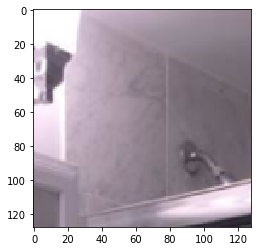

In [99]:
plt.imshow(pix_patches[500])

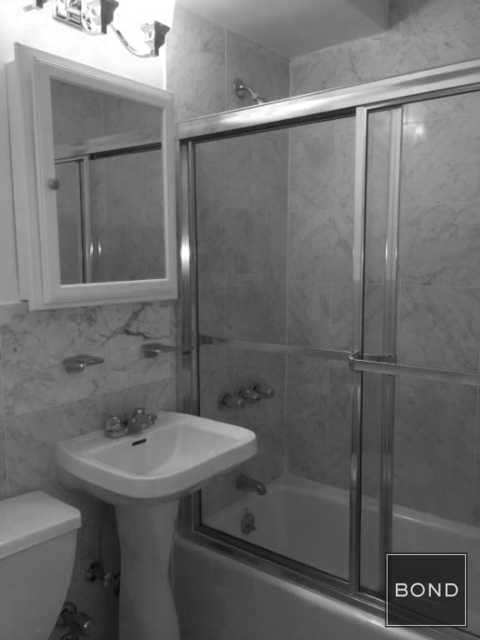

In [104]:
r

In [113]:
r_mean = np.array(r.getdata()).mean()
g_mean = np.array(g.getdata()).mean()
b_mean = np.array(b.getdata()).mean()

In [114]:
r_mean

109.56116861979167

In [115]:
g_mean

102.51517252604167

In [116]:
b_mean

109.90766927083334

In [120]:
r_var = np.array(r.getdata()).var()
g_var = np.array(g.getdata()).var()
b_var = np.array(b.getdata()).var()

In [119]:
r_var

1873.5020656916197

In [121]:
g_var

1562.48712005487

In [122]:
b_var

1763.6886755572853

## Todo: get "Dominant" color
https://stackoverflow.com/questions/3241929/python-find-dominant-most-common-color-in-an-image